# Data Inspection

In [10]:
import sqlite3
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt


In [11]:
# Path to the SQLite database
sqlite_file = '../data/data.sqlite'

# Connect to the database
if os.path.exists(sqlite_file):
    print("Connecting to SQLite database...")
    conn = sqlite3.connect(sqlite_file)

    # List all tables
    print("\n=== Tables in SQLite Database ===")
    tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
    tables = pd.read_sql(tables_query, conn)
    print(tables)

    # Inspect each table
    for table_name in tables['name']:
        print(f"\n=== Schema of Table: {table_name} ===")
        schema_query = f"PRAGMA table_info({table_name});"
        schema = pd.read_sql(schema_query, conn) 
        print(schema)

        print(f"\n=== First 5 Rows of Table: {table_name} ===")
        preview_query = f"SELECT * FROM {table_name} LIMIT 5;"
        preview = pd.read_sql(preview_query, conn)
        print(preview)

    # Close connection
    conn.close()
    print("\nDatabase exploration complete.")

else:
    print("SQLite database not found. Please check the file path.")


Connecting to SQLite database...

=== Tables in SQLite Database ===
             name
0  quarterly_data
1     annual_data

=== Schema of Table: quarterly_data ===
   cid              name  type  notnull dflt_value  pk
0    0              date  TEXT        0       None   0
1    1  UnemploymentRate  REAL        0       None   0
2    2           GDPRate  REAL        0       None   0

=== First 5 Rows of Table: quarterly_data ===
         date  UnemploymentRate    GDPRate
0  2014-07-01               6.1  18406.941
1  2014-10-01               5.7  18500.031
2  2015-01-01               5.5  18666.621
3  2015-04-01               5.4  18782.243
4  2015-07-01               5.1  18857.418

=== Schema of Table: annual_data ===
   cid              name  type  notnull dflt_value  pk
0    0              date  TEXT        0       None   0
1    1  UnemploymentRate  REAL        0       None   0
2    2           GDPRate  REAL        0       None   0

=== First 5 Rows of Table: annual_data ===
         d

In [12]:
# Reconnect to the SQLite database
conn = sqlite3.connect(sqlite_file)

# Dictionary to store cleaned data
cleaned_tables = {}

# Process each table
for table_name in tables['name']:
    print(f"\n=== Processing Table: {table_name} ===")
    
    # Load the table
    query = f"SELECT * FROM {table_name};"
    df = pd.read_sql_query(query, conn)
    
    print("\nChecking for missing values...")
    missing_summary = df.isnull().sum()
    print(missing_summary)

    # Example strategy: Fill or drop missing values
    if missing_summary.sum() > 0:
        print("\nHandling missing values...")
        df.fillna(method='ffill', inplace=True)  # Forward fill as an example

    print("\nChecking and converting data types...")
    print(df.dtypes)
    
    # Convert date columns
    for col in df.columns:
        if "date" in col.lower():
            df[col] = pd.to_datetime(df[col], errors='coerce')

    print("\nNormalizing column names...")
    df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
    
    print("\nChecking for duplicates...")
    duplicate_count = df.duplicated().sum()
    print(f"Found {duplicate_count} duplicate rows.")
    if duplicate_count > 0:
        df.drop_duplicates(inplace=True)

    # Store the cleaned table
    cleaned_tables[table_name] = df

    # Save the cleaned table back to the database
    cleaned_table_name = f"{table_name}_cleaned"
    print(f"\nSaving cleaned table as {cleaned_table_name}...")
    df.to_sql(cleaned_table_name, conn, if_exists='replace', index=False)

# Close the connection
conn.close()
print("\nData preparation completed successfully!")



=== Processing Table: quarterly_data ===

Checking for missing values...
date                0
UnemploymentRate    0
GDPRate             0
dtype: int64

Checking and converting data types...
date                 object
UnemploymentRate    float64
GDPRate             float64
dtype: object

Normalizing column names...

Checking for duplicates...
Found 0 duplicate rows.

Saving cleaned table as quarterly_data_cleaned...

=== Processing Table: annual_data ===

Checking for missing values...
date                0
UnemploymentRate    0
GDPRate             0
dtype: int64

Checking and converting data types...
date                 object
UnemploymentRate    float64
GDPRate             float64
dtype: object

Normalizing column names...

Checking for duplicates...
Found 0 duplicate rows.

Saving cleaned table as annual_data_cleaned...

Data preparation completed successfully!



=== EDA for Table: quarterly_data ===

Summary statistics:
                       date  unemploymentrate       gdprate
count                    41         41.000000     41.000000
unique                   41               NaN           NaN
top     2014-07-01 00:00:00               NaN           NaN
freq                      1               NaN           NaN
mean                    NaN          4.748780  20641.702537
std                     NaN          1.713056   1484.353886
min                     NaN          3.500000  18406.941000
25%                     NaN          3.800000  19304.352000
50%                     NaN          4.200000  20548.793000
75%                     NaN          5.100000  21919.222000
max                     NaN         13.000000  23400.294000

Checking column distributions:


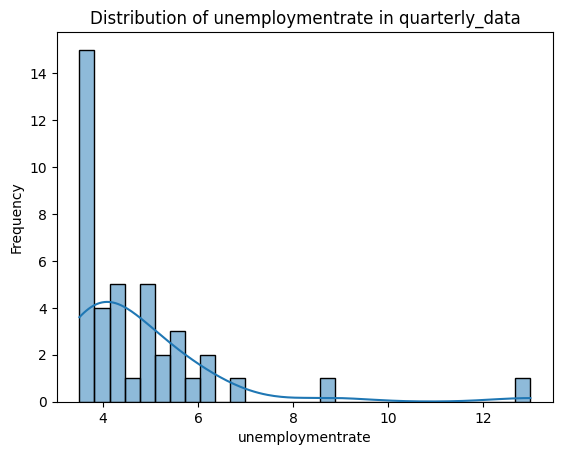

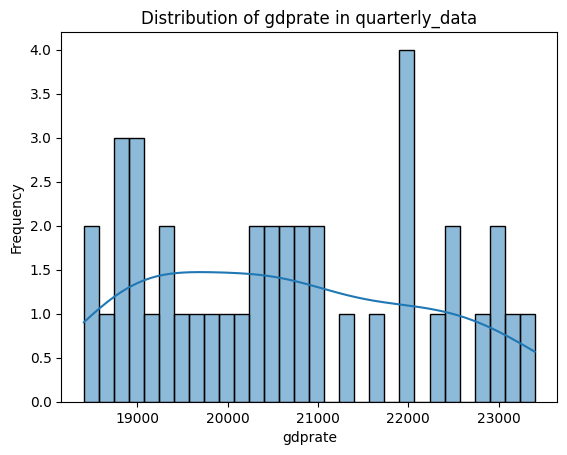


Analyzing relationships between variables:


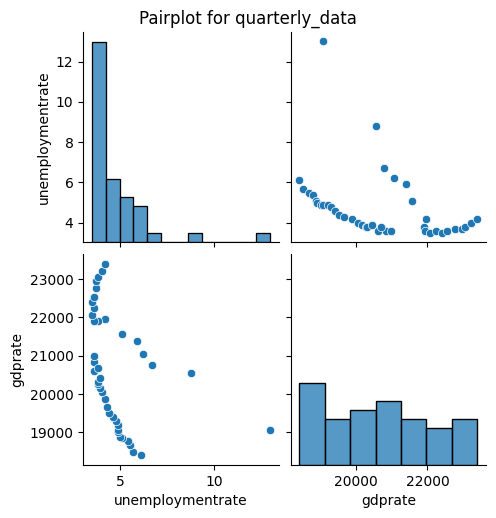


Correlations between numeric columns:
                  unemploymentrate   gdprate
unemploymentrate          1.000000 -0.396134
gdprate                  -0.396134  1.000000


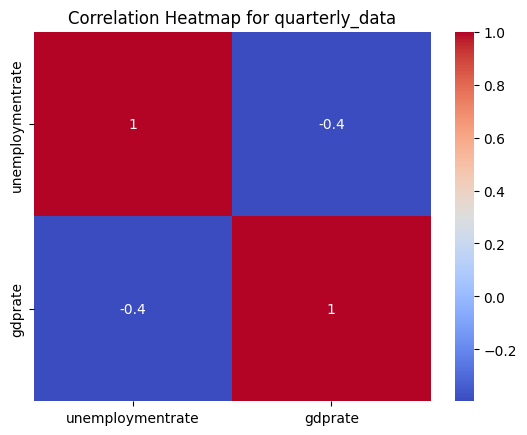


Analyzing time-series data (if applicable):


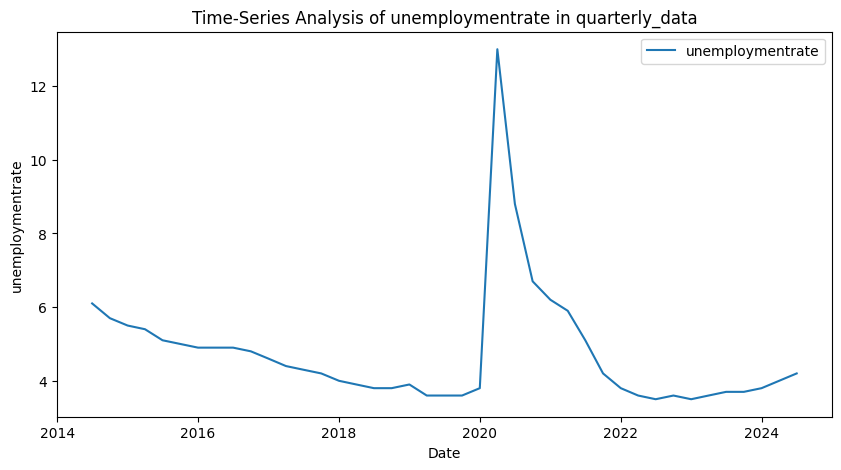

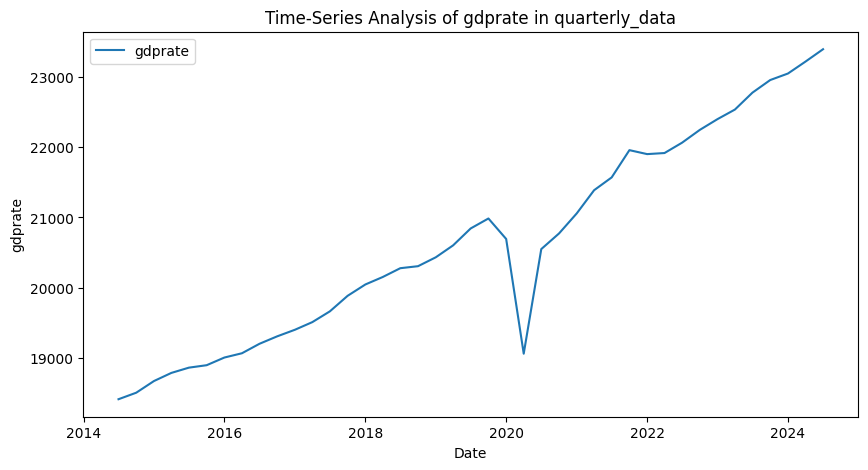


=== EDA for Table: annual_data ===

Summary statistics:
                       date  unemploymentrate       gdprate
count                    64         64.000000     64.000000
unique                   64               NaN           NaN
top     1960-01-01 00:00:00               NaN           NaN
freq                      1               NaN           NaN
mean                    NaN          5.923438  45736.325500
std                     NaN          1.619400  22634.390824
min                     NaN          3.500000  14001.090000
25%                     NaN          4.850000  25268.680000
50%                     NaN          5.600000  40906.349500
75%                     NaN          7.025000  66061.888000
max                     NaN          9.700000  90684.386000

Checking column distributions:


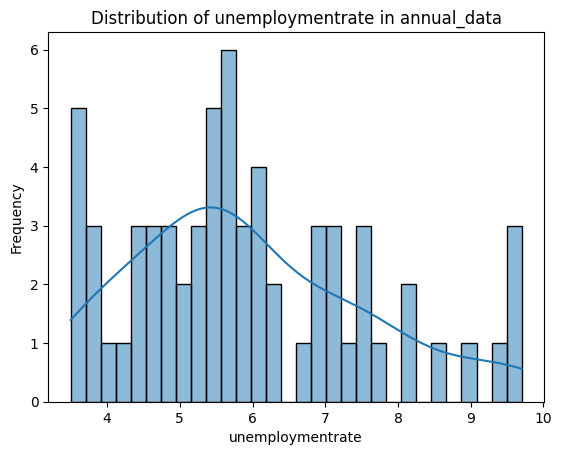

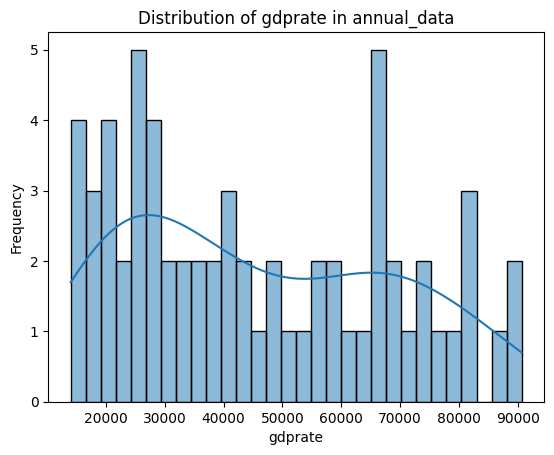


Analyzing relationships between variables:


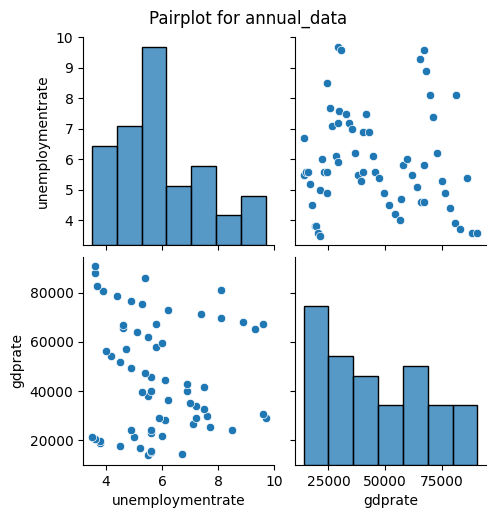


Correlations between numeric columns:
                  unemploymentrate   gdprate
unemploymentrate          1.000000 -0.092677
gdprate                  -0.092677  1.000000


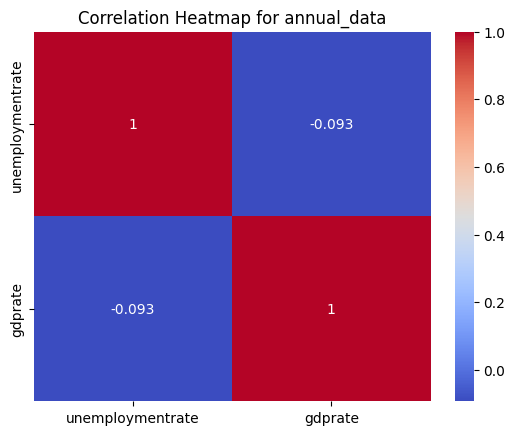


Analyzing time-series data (if applicable):


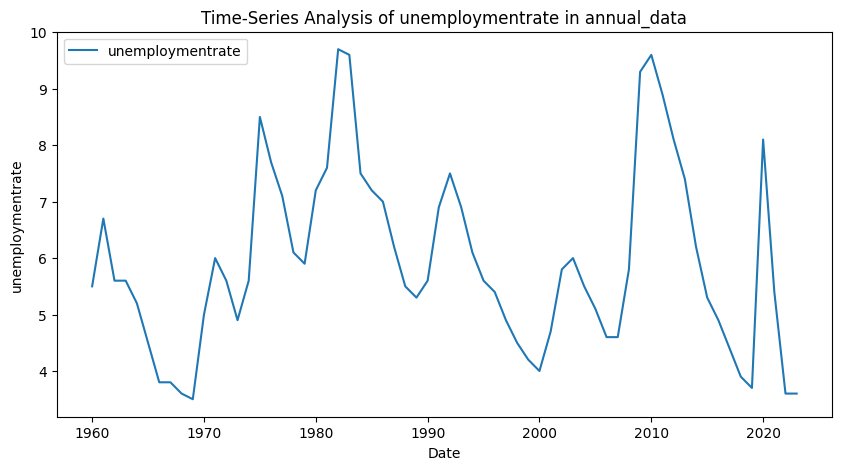

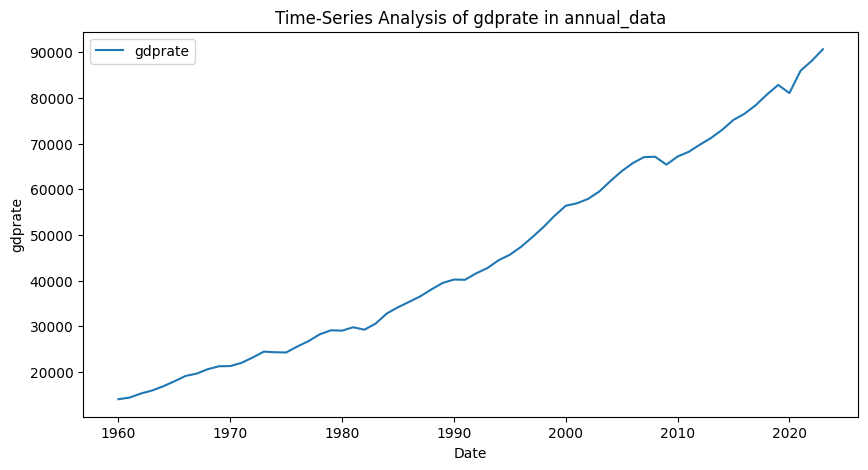


EDA completed!


In [13]:

# Reconnect to SQLite database to load cleaned data
conn = sqlite3.connect(sqlite_file)

# Load all cleaned tables
cleaned_data = {}
for table_name in tables['name']:
    cleaned_table_name = f"{table_name}_cleaned"
    query = f"SELECT * FROM {cleaned_table_name};"
    df = pd.read_sql_query(query, conn)
    cleaned_data[table_name] = df

# Close the connection
conn.close()

# Example: Exploratory analysis of each table
for table_name, df in cleaned_data.items():
    print(f"\n=== EDA for Table: {table_name} ===")

    print("\nSummary statistics:")
    print(df.describe(include='all'))

    print("\nChecking column distributions:")
    for col in df.select_dtypes(include=['float', 'int']):
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f"Distribution of {col} in {table_name}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.show()

    print("\nAnalyzing relationships between variables:")
    if len(df.select_dtypes(include=['float', 'int']).columns) > 1:
        sns.pairplot(df.select_dtypes(include=['float', 'int']))
        plt.suptitle(f"Pairplot for {table_name}", y=1.02)
        plt.show()

    print("\nCorrelations between numeric columns:")

    # Filter for numeric columns only
    numeric_df = df.select_dtypes(include=['float', 'int'])

    if not numeric_df.empty:
        corr = numeric_df.corr()
        print(corr)
        sns.heatmap(corr, annot=True, cmap='coolwarm')
        plt.title(f"Correlation Heatmap for {table_name}")
        plt.show()
    else:
        print(f"No numeric columns found in {table_name} to compute correlations.")


    print("\nAnalyzing time-series data (if applicable):")
    for col in df.columns:
        if "date" in col:
            df[col] = pd.to_datetime(df[col])
            df.set_index(col, inplace=True)
            df.sort_index(inplace=True)
            numeric_cols = df.select_dtypes(include=['float', 'int']).columns
            for num_col in numeric_cols:
                plt.figure(figsize=(10, 5))
                plt.plot(df.index, df[num_col], label=num_col)
                plt.title(f"Time-Series Analysis of {num_col} in {table_name}")
                plt.xlabel("Date")
                plt.ylabel(num_col)
                plt.legend()
                plt.show()

print("\nEDA completed!")


In [14]:
# Reset the index to make 'DATE' a column again
df = df.reset_index()

# Verify the changes
print(df.head())


        date  unemploymentrate    gdprate
0 1960-01-01               5.5  14001.090
1 1961-01-01               6.7  14360.265
2 1962-01-01               5.6  15240.493
3 1963-01-01               5.6  15904.567
4 1964-01-01               5.2  16821.109


date column type after conversion: datetime64[ns]


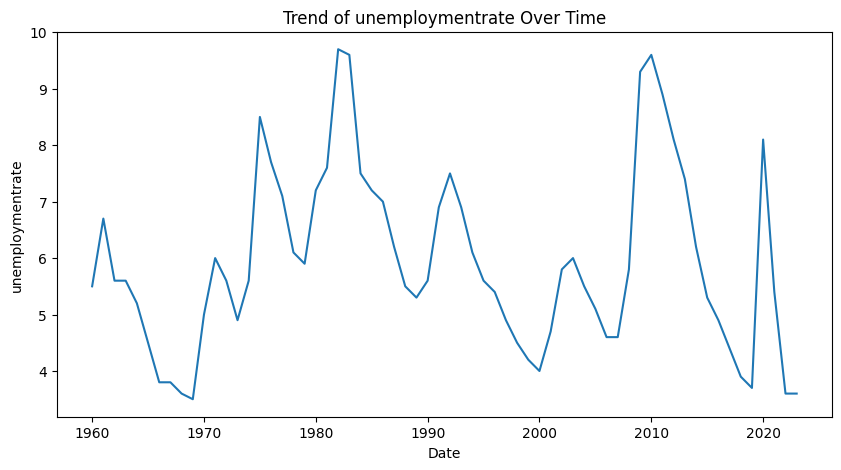

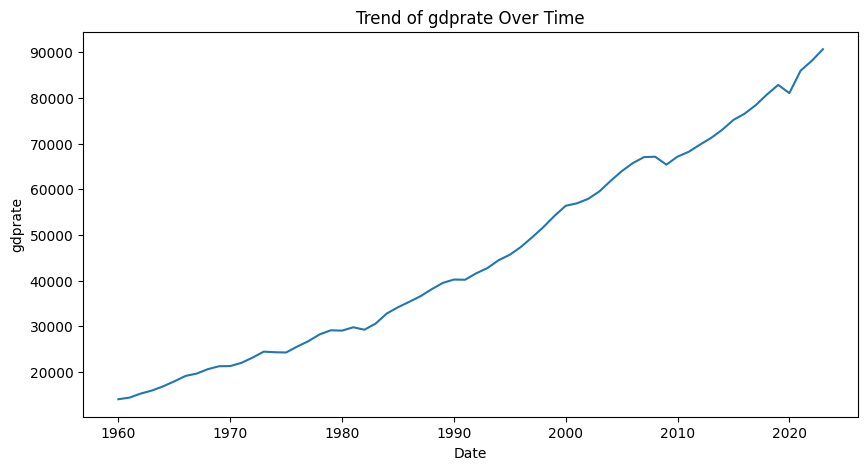

In [15]:
# Convert 'date' to datetime if it's still not in the correct format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Verify the conversion
print(f"date column type after conversion: {df['date'].dtype}")

# Now attempt plotting again
for col in df.columns:
    if col != 'date':  # Exclude the 'date' column from being plotted
        plt.figure(figsize=(10, 5))
        sns.lineplot(data=df, x='date', y=col)
        plt.title(f"Trend of {col} Over Time")
        plt.xlabel("Date")
        plt.ylabel(col)
        plt.show()


In [16]:
# Calculate the correlation between unemployment rate and GDP growth rate
correlation = df['unemploymentrate'].corr(df['gdprate'])
print(f"Correlation between unemployment rate and GDP growth rate: {correlation}")


Correlation between unemployment rate and GDP growth rate: -0.09267661168219422


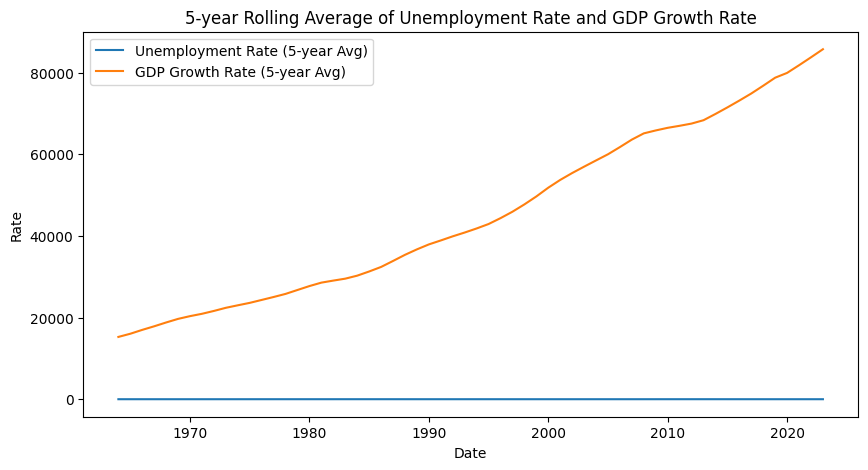

In [17]:
# Calculate rolling averages (e.g., 5-year rolling average)
df['unemploymentrate_rolling'] = df['unemploymentrate'].rolling(window=5).mean()
df['gdprate_rolling'] = df['gdprate'].rolling(window=5).mean()

# Plot rolling averages
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='date', y='unemploymentrate_rolling', label='Unemployment Rate (5-year Avg)')
sns.lineplot(data=df, x='date', y='gdprate_rolling', label='GDP Growth Rate (5-year Avg)')
plt.title("5-year Rolling Average of Unemployment Rate and GDP Growth Rate")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.legend()
plt.show()


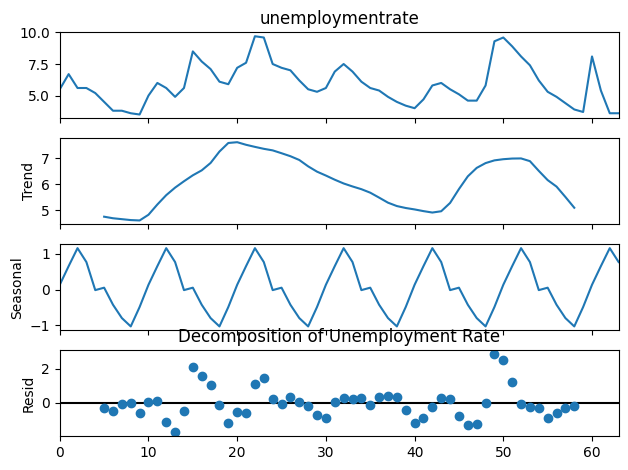

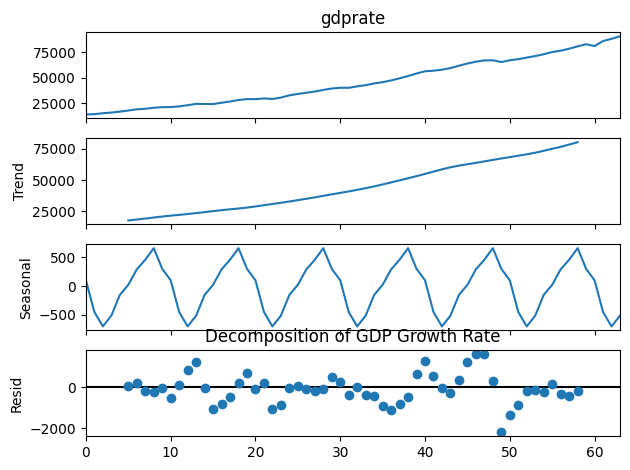

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose unemployment rate and GDP rate
unemployment_decomposition = seasonal_decompose(df['unemploymentrate'], model='additive', period=10)
gdp_decomposition = seasonal_decompose(df['gdprate'], model='additive', period=10)

# Plot decompositions
unemployment_decomposition.plot()
plt.title("Decomposition of Unemployment Rate")
plt.show()

gdp_decomposition.plot()
plt.title("Decomposition of GDP Growth Rate")
plt.show()


In [19]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model on the unemployment rate
model = ARIMA(df['unemploymentrate'], order=(1, 1, 1))  # Adjust order as necessary
model_fit = model.fit()

# Make predictions
forecast = model_fit.forecast(steps=10)
print(f"10-step forecast for unemployment rate: {forecast}")


10-step forecast for unemployment rate: 64    3.107567
65    3.503727
66    3.185018
67    3.441418
68    3.235145
69    3.401091
70    3.267588
71    3.374990
72    3.288586
73    3.358098
Name: predicted_mean, dtype: float64


Pearson Correlation between Unemployment Rate and GDP Growth Rate: -0.09267661168219422


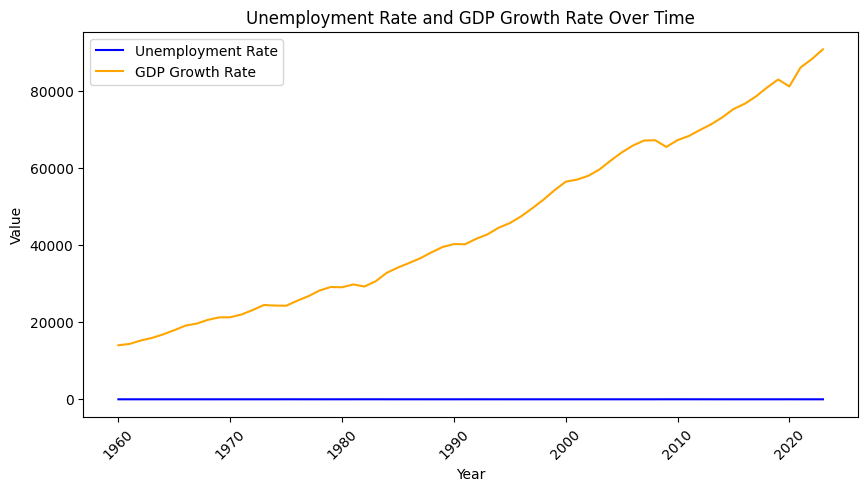

In [20]:
# Calculate the Pearson correlation coefficient between unemployment rate and GDP growth rate
correlation = df['unemploymentrate'].corr(df['gdprate'])

# Display the correlation coefficient
print(f"Pearson Correlation between Unemployment Rate and GDP Growth Rate: {correlation}")

# Plot the two series to visualize the relationship
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['unemploymentrate'], label='Unemployment Rate', color='blue')
plt.plot(df['date'], df['gdprate'], label='GDP Growth Rate', color='orange')
plt.title("Unemployment Rate and GDP Growth Rate Over Time")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.xticks(rotation=45)
plt.show()


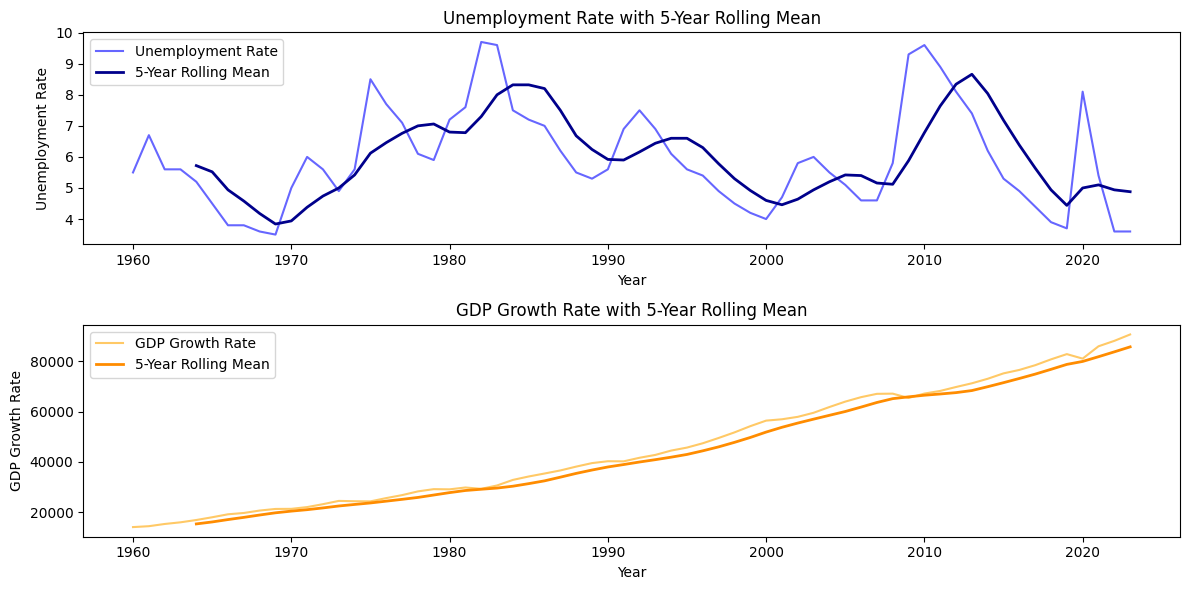

In [21]:
# Calculate rolling mean with a window size of 5 years (adjust as needed)
df['unemploymentrate_rolling'] = df['unemploymentrate'].rolling(window=5).mean()
df['gdprate_rolling'] = df['gdprate'].rolling(window=5).mean()

# Plot the original data and rolling mean for both series
plt.figure(figsize=(12, 6))

# Plot Unemployment Rate with Rolling Mean
plt.subplot(2, 1, 1)
plt.plot(df['date'], df['unemploymentrate'], label='Unemployment Rate', color='blue', alpha=0.6)
plt.plot(df['date'], df['unemploymentrate_rolling'], label='5-Year Rolling Mean', color='darkblue', linewidth=2)
plt.title("Unemployment Rate with 5-Year Rolling Mean")
plt.xlabel("Year")
plt.ylabel("Unemployment Rate")
plt.legend()

# Plot GDP Growth Rate with Rolling Mean
plt.subplot(2, 1, 2)
plt.plot(df['date'], df['gdprate'], label='GDP Growth Rate', color='orange', alpha=0.6)
plt.plot(df['date'], df['gdprate_rolling'], label='5-Year Rolling Mean', color='darkorange', linewidth=2)
plt.title("GDP Growth Rate with 5-Year Rolling Mean")
plt.xlabel("Year")
plt.ylabel("GDP Growth Rate")
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


Pearson Correlation Coefficient: -0.09


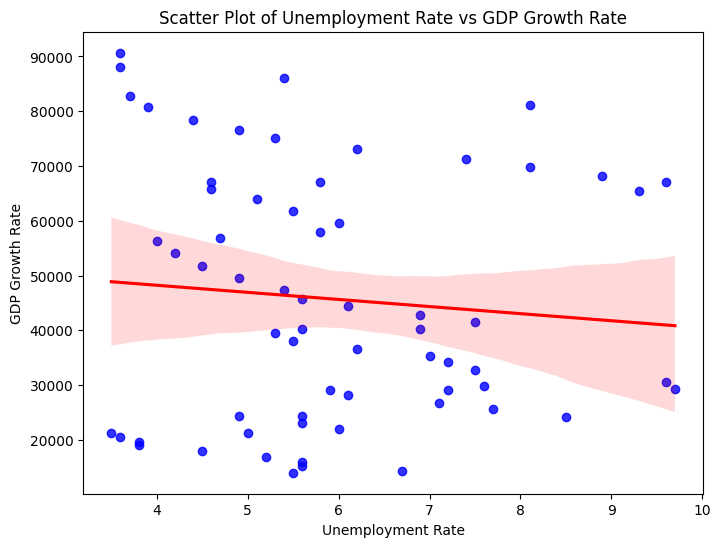

In [22]:
import seaborn as sns
from scipy.stats import pearsonr

# Calculate the Pearson correlation coefficient
correlation, _ = pearsonr(df['unemploymentrate'], df['gdprate'])
print(f"Pearson Correlation Coefficient: {correlation:.2f}")

# Plot the scatter plot with regression line
plt.figure(figsize=(8, 6))
sns.regplot(x='unemploymentrate', y='gdprate', data=df, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.title("Scatter Plot of Unemployment Rate vs GDP Growth Rate")
plt.xlabel("Unemployment Rate")
plt.ylabel("GDP Growth Rate")
plt.show()
